
A feladat célja a Titanic űrhajó balesetekor dimenziót váltó utasainak megjóslása. A feladat tartalmaz egy training adathalmazt és egy teszt adathalmazt. A LazyPredict könyvtárat használva 27 klasszifikációs modelt fogunk vizsgálni.

Használt könyvtárak

In [38]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas
!pip3 install -U jinja2

clear_output()

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')


A feltáró adatelemzéshez használt eszközök
* Hiányzó értékek vizsgálata
* Alapvető statisztikai mutatók
* Hiányzó értékek eloszlása

In [26]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

Oszlopok

- `PassengerId` - Egyedi utasazonosító.
- `HomePlanet` - Utas indulási bolygója.
- `CryoSleep` - Utas cryo álmot kért-e.
- `Cabin` - Az utas kabin száma.
- `Destination` - Célbolygó.
- `Age` - Utas kora.
- `VIP` - VIP ellátást kért-e.
- `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Az utas költésének kategóriái.
- `Name` - Az utas teljes neve.
- `Transported` - Az utas teleportált-e a másik dimenzióba. Ezt akarjuk megjósolni!



A tanulási adatok jellemzői:

In [27]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [28]:
print('Tanulási adathalmaz:')
print(f'Sorok: {train.shape[0]}')
print(f'Oszlopok: {train.shape[1]}')
print(f'Értékek: {train.count().sum()}')
print(f'Hiányzó értékek: {sum(train.isna().sum())}')

Tanulási adathalmaz:
Sorok: 8693
Oszlopok: 14
Értékek: 119378
Hiányzó értékek: 2324


Hiányzó értékek oszloponként

In [29]:
print(train.isna().sum().sort_values(ascending = False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


Leíró statisztikai mutatók (Elhelyezkedési mutatók) `count`, `mean`, `standard deviation`, `minimum`, `1st quartile`, `median`, `3rd quartile` és `maximum`.

In [30]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


A teszt adatok jellemzői:

In [31]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [32]:
print('Teszt adathalmaz:')
print(f'Sorok: {test.shape[0]}')
print(f'Oszlopok: {test.shape[1]}')
print(f'Értékek: {test.count().sum()}')
print(f'Hiányzó értékek: {sum(test.isna().sum())}')

Teszt adathalmaz:
Sorok: 4277
Oszlopok: 13
Értékek: 54484
Hiányzó értékek: 1117


Hiányzó értékek oszloponként

In [33]:
print((test.isna().sum().sort_values(ascending = False)))

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


Leíró statisztikai mutatók (Elhelyezkedési mutatók) `count`, `mean`, `standard deviation`, `minimum`, `1st quartile`, `median`, `3rd quartile` és `maximum`.

In [34]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


A tanulási adathalmaz oszlopainak vizualizációja

In [35]:
train.drop(["PassengerId"] , axis = 1 , inplace = True)
test.drop(["PassengerId"] , axis = 1 , inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [40]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


### Hiányzó értékek eloszlása

Hiányzó értékek oszloponként

In [ ]:
test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Tanuló adatok", "Teszt adatok"] ,
                    x_title="Hiányzó értékek")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Oszloponkénti hiányzó értékek eloszlása", title_x=0.5)

Hiányzó értékek soronként

In [ ]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Tanuló adatok", "Teszt adatok"] ,
                    x_title="Hiányzó értékek",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Soronkénti hiányzó értékek eloszlása", title_x=0.5)

Megfigyelések
 
* A soronkénti hiányzó értékek maximuma a 3, a minimuma a 0.
* A hiányzó értékek eloszlása nagyon hasonló a tanuló és teszt adathalmaz esetében.
* Az adatok körübelül 76%-ánál nincsen hiányzó adat.
* A maradék 24%-nál 1 és 3 között van.

Folytonos és kategória típusú attribútumok

In [42]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'Attribútumok száma: {len(FEATURES)}')
print(f'Kategória típusú attribútumok száma: {len(cat_features)}')
print(f'Folytonos attribútumok száma: {len(cont_features)}')
print(f'Szöveges attribútumok száma: {len(text_features)}')

labels=['Kategóriák', 'Folytonos', "Szöveges"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Attribútumok száma: 12
Kategória típusú attribútumok száma: 4
Folytonos attribútumok száma: 6
Szöveges attribútumok száma: 2


Megfigyelések
 
* 12 attribútum van összesen
* 6 folytons
* 2 szöveges
* 4 kategória típusú
* CryoSleep és a VIP attribútumok binárisak

A kor eloszlása

In [59]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Tanuló"
test_age["type"] = "Teszt"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "A kor eloszlása" , title_x = 0.5)
fig.show()

A kategória típusú attribútumok eloszlása

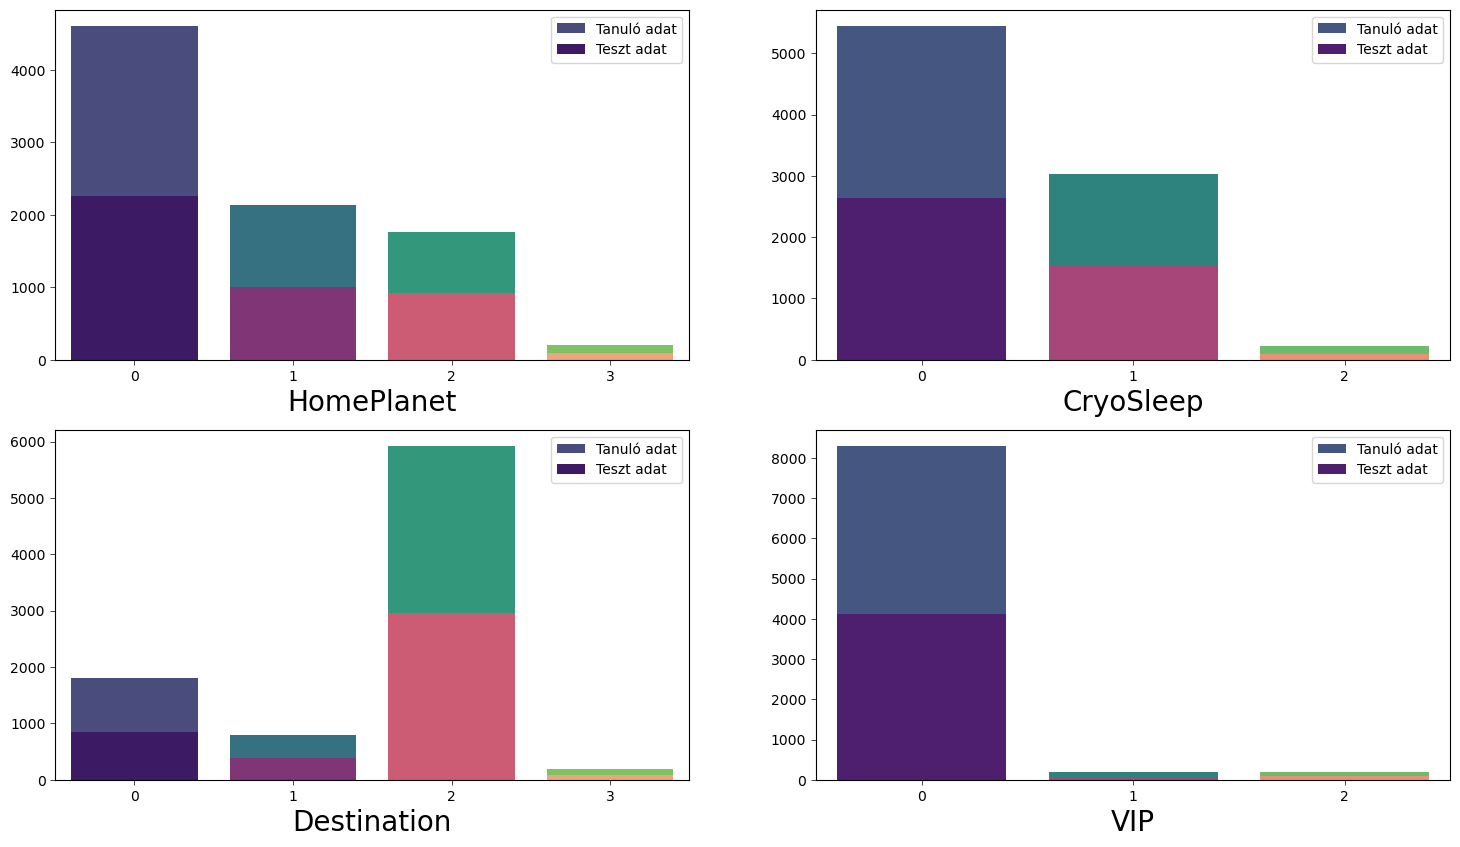

In [61]:
if len(cat_features) == 0 :
    print("Nincsenek attribútumok")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col],ax = axes[r,c] ,palette = "viridis", label='Tanuló adat')
            sns.countplot(test[col],ax = axes[r,c] ,palette = "magma", label='Teszt adat')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

Korrelációs mátrix

In [62]:
fig = px.imshow(train.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

Hiányzó értékek imputációja

In [47]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy=STRATEGY )
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace=True)
test["HomePlanet"].fillna('Z', inplace=True)

Kategóriás változók kódolása

In [48]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(train,test ,label_cols)

Tanuló és teszt adathalmazok véletlenszerű létrehozása

In [49]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

27 különböző klasszifikáció futtatása és vizsgálata

In [50]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

A 15 legjobban  teljesítő modell

In [51]:
models[:15]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.24
XGBClassifier,0.78,0.78,0.78,0.78,1.58
AdaBoostClassifier,0.77,0.77,0.77,0.77,0.37
RandomForestClassifier,0.77,0.77,0.77,0.77,0.89
NuSVC,0.77,0.77,0.77,0.77,4.09
LogisticRegression,0.77,0.77,0.77,0.77,0.06
SVC,0.77,0.77,0.77,0.77,2.97
ExtraTreesClassifier,0.76,0.76,0.76,0.76,0.97
LinearSVC,0.76,0.76,0.76,0.76,0.71


Az eredmények vizualizációja

In [67]:
line = px.line(data_frame= models ,y =["Accuracy"] , markers = True)
line.update_xaxes(title="Modellek",
              rangeslider_visible = False)
line.update_yaxes(title = "Pontosság")
line.update_traces(line_color="red")
line.update_layout(showlegend = True,
    title = {
        'text': 'Egyes modellek pontossága',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [68]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Modellek",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC érték")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC és F1 értékek vs modellenként',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

In [73]:
line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Idő(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'Modellek ideje',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

LGBM

In [55]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :50,
    'learning_rate' : 0.08
}

lgb_predictions = 0
lgb_scores = []
lgb_fimp = []
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_STATE)
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES], train.iloc[valid_idx][LGBM_FEATURES]
    y_train , y_valid = train[TARGET].iloc[train_idx] , train[TARGET].iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, y_train,verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(test[LGBM_FEATURES]) 
    lgb_predictions += test_preds/FOLDS
print("")
print("Mean Accuracy :", np.mean(lgb_scores))


========== Fold=1 ==========
Fold=1, Accuracy score: 0.81%, Run Time: 0.14s

========== Fold=2 ==========
Fold=2, Accuracy score: 0.78%, Run Time: 0.16s

========== Fold=3 ==========
Fold=3, Accuracy score: 0.79%, Run Time: 0.15s

========== Fold=4 ==========
Fold=4, Accuracy score: 0.79%, Run Time: 0.17s

========== Fold=5 ==========
Fold=5, Accuracy score: 0.81%, Run Time: 0.15s

Mean Accuracy : 0.7958136330880743


Az attribútumok fontossága és relevanciája

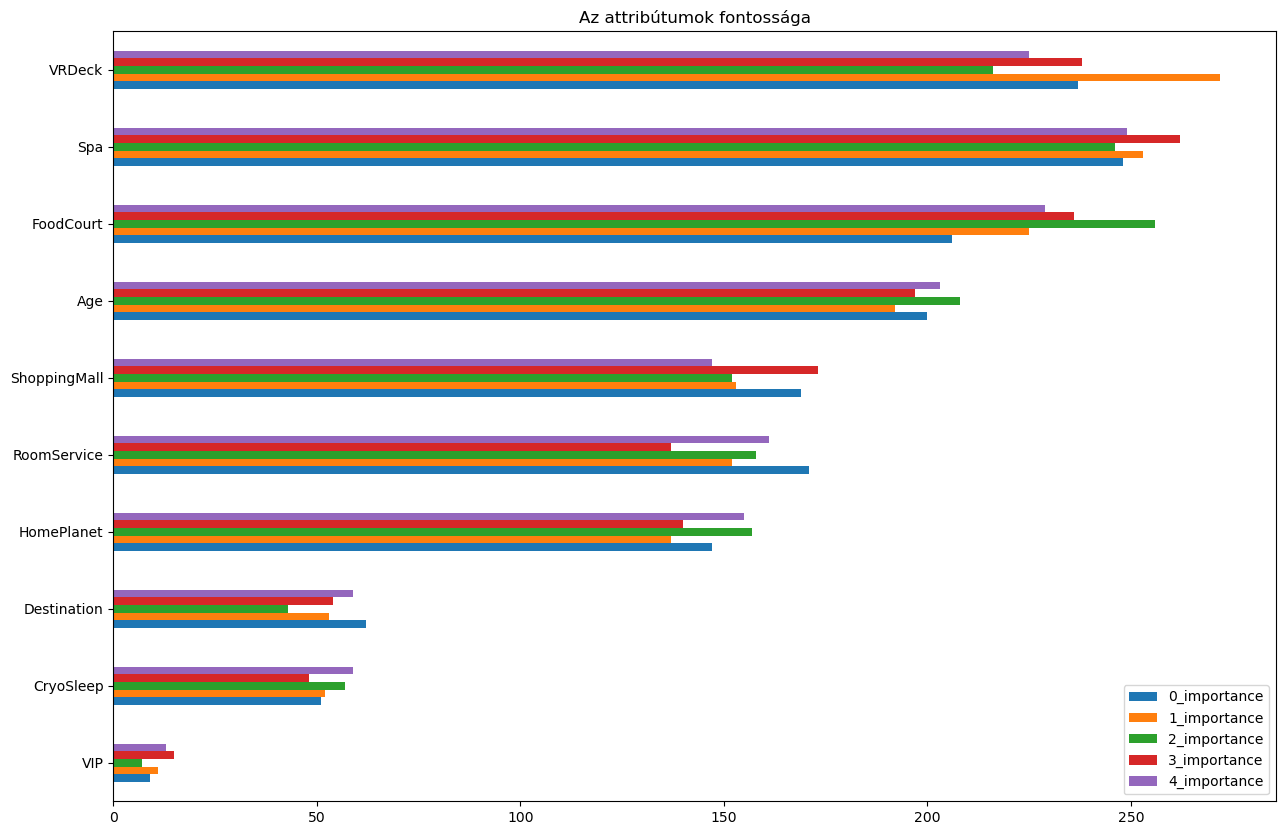

In [72]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Az attribútumok fontossága')
plt.show()

Az LGB jóslás eredményének elmentése

In [71]:
submission = pd.read_csv("sample_submission.csv")

submission[TARGET] = lgb_predictions.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
